In [60]:
using Plots

## Baseline Parameterization

In [61]:
k = 6  # price_intervals
alpha = 0.3  # step_size
delta = 0.95  # discount_factor

P = 0:1/k:1  # prices/action space (state space is competitor prices)

# convergence if Q doesn't change for 100,000 consecutive periods (Calvano 2020, missing from Klein 2021)
conv_len = 100_000  

100000

## Learning

### Define functions

In [62]:
mutable struct Firm
    Q::AbstractMatrix  # Q matrix ∈ M(actions, states)
    prices::Array  # price history (save all for later calculations/plotting)
end

"""Convert price p to index in Q matrix"""
p2in(p) = Int(p * k + 1)

p2in

In [63]:
"""Calculate demand (linear)"""
function demand(p_i, p_j)
    if p_i < p_j
        1 - p_i
    elseif p_i == p_j
        0.5 * (1 - p_i)
    else
        0
    end
end


"""Calculate profit"""
profit(p_i, p_j) = p_i * demand(p_i, p_j)

profit

In [64]:
"""Calculate argmax but return random if multiple found"""
rand_argmax(arr::Array) = rand(findall(x -> x == maximum(arr), arr))

rand_argmax

In [65]:
"""Calculate argmax but return maximum if multiple found"""
max_argmax(arr::Array) = maximum(findall(x -> x == maximum(arr), arr))

max_argmax

In [66]:
 """Return optimal strategy with ties chosen randomly"""
function opt_strategy_rand(Q::Matrix, p::Number)
    (rand_argmax(Q[:, p2in(p)]) - 1) / k
end

opt_strategy_rand

In [67]:
"""Return optimal strategy with ties given to the max price"""
function opt_strategy_max(Q::Matrix, p::Number)
    (max_argmax(Q[:, p2in(p)]) - 1) / k
end

opt_strategy_max

In [68]:
"""Update Q matrix at time t"""
function update_Q!(Q_i::Matrix, p_i::Array, p_j::Array, t::Int)
    ind_i, ind_j = p2in(p_i[t]), p2in(p_j[t])
    prev_est = Q_i[ind_i, ind_j]
    new_est =  profit(p_i[t], p_j[t]) + delta*profit(p_i[t], p_j[t+1]) + delta^2*maximum(Q_i[:, p2in(p_j[t+1])])
    Q_i[ind_i, ind_j] = (1 - alpha) * prev_est + alpha * new_est

    return Q_i
end

update_Q!

In [69]:
"""Run simulation of duopoly for T periods"""
function simulate_duopoly(T::Int)
    
    # initialize firms w/ t = {1, 3}
    Q1 = zeros(length(P), length(P))
    Q2 = zeros(length(P), length(P))
            
    prices1 = Array{Float64}(undef,T)
    prices2 = Array{Float64}(undef,T)
            
    prices1[1] = prices1[2] = rand(P)  # t=1
    prices2[1] = prices2[2] = rand(P)  # t=2
    prices1[3], prices2[3] = rand(P), prices2[2]  # t=3
    
    firms = (Firm(Q1, prices1), Firm(Q2, prices2))
    
    converged = false
    prev_Q = [copy(Q1), copy(Q2)]
    unchanged = 0
    
    # update Q matricies
    i, j = 2, 1  # i = firm2 b/c t=4
    for t in 4:T
    
        # update Q at t-2
        update_Q!(firms[i].Q, firms[i].prices, firms[j].prices, t-2)
        
        # update unchanged and check for convergence
        firms[i].Q == prev_Q[i] ? (unchanged += 1) : (unchanged = 0)
        unchanged == conv_len && (converged = true)
        prev_Q[i] = copy(firms[i].Q)
        
        # set new prices
        epsilon = (0.000001)^(t/T)  # ϵ = (1 - θ)^t where decay parameter θ is set s.t. ϵ_T = .0001%
        firms[i].prices[t] = rand() < epsilon ? rand(P) : opt_strategy_rand(firms[i].Q, firms[j].prices[t-1])
        firms[j].prices[t] = firms[j].prices[t-1] 
        
        # swap i and j b/c sequential
        i, j = j, i  
    end
    
    return firms, converged
end

simulate_duopoly

In [70]:
"""Calculate profit history given price histories"""
function getprofits(prices1, prices2)
    profits1 = [profit(prices1[t], prices2[t]) for t in 1:length(prices1)]
    profits2 = [profit(prices2[t], prices1[t]) for t in 1:length(prices1)] 
    profits1, profits2
end

getprofits

In [71]:
"""Plot price and profit histories"""
function makeplots(prices1, prices2, profits1, profits2, step::Int; titled = "")
    x = 1:step:length(prices1)
    p1 = plot(x, [prices1[x] prices2[x]], ylim =(0, 1), title = "Price (every $(step)th)")
    p2 = plot(x, [profits1[x] profits2[x]], title = "Profit (every $(step)th)")
    plot(p1, p2, label=["Firm 1" "Firm 2"], layout=(2,1), plot_title=titled, titlelocation=:left)
end

makeplots

### Run experiment

In [73]:
T = 500_000

firms, converged = simulate_duopoly(T)
firm1, firm2 = firms

# calculate profit history
profits1, profits2 = getprofits(firm1.prices, firm2.prices)

@show converged
firm1.prices[end], profits1[end], firm2.prices[end], profits2[end]

converged = true


(0.5, 0.125, 0.5, 0.125)

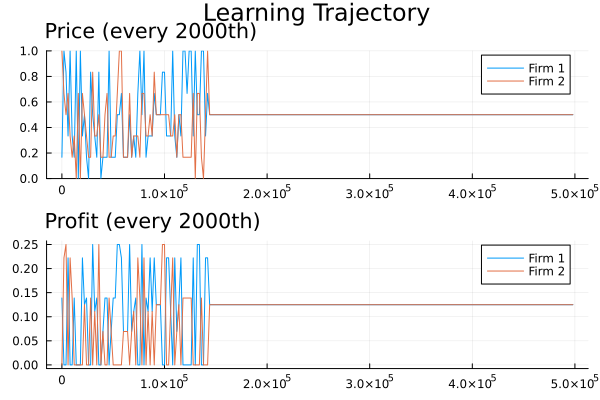

In [77]:
makeplots(firm1.prices, firm2.prices, profits1, profits2, 2_000, titled = "Learning Trajectory")

## Performance metrics

### Define metrics

In [78]:
"""Calculate optimal Q-function given current competitor strategy"""
function optimal_Q(firm_i::Firm, firm_j::Firm; max_periods=10_000_000)
    
    main = Firm(copy(firm_i.Q), firm_i.prices[end-1:end])
    comp = Firm(firm_j.Q, firm_j.prices[end-1:end])
    
    firms = (main, comp)
    
    # loop over all action-state pairs in Q until convergence
    prev_Q = copy(firms[1].Q)
    unchanged = 0  # periods Q has remained unchanged
    
    i, j = 1, 2
    periods = 0
    while true
        
        # stop if hasnt converged
        periods == max_periods && break
        
        # update Q if firm is main (to get optimal)
        if i == 1
            
            update_Q!(firms[1].Q, firms[1].prices, firms[2].prices, 1)
            
            # update unchanged and check for convergence
            firms[1].Q == prev_Q ? (unchanged += 1) : (unchanged = 0)
            unchanged == conv_len && break
            prev_Q = copy(firms[1].Q)
            
            # set epsilon to .1 b/c cant use decay since dont know when will converge 
            # perhaps theres a better value / way to decay?
            epsilon = .1
            firms[1].prices[2] = rand() < epsilon ? rand(P) : opt_strategy_rand(firms[1].Q, firms[2].prices[2])
        else
            firms[2].prices[2] = opt_strategy_max(firms[2].Q, firms[1].prices[2])
            
        end
        firms[j].prices[1] = firms[j].prices[2]  # future price becomes current price 
        
        i, j = j, i  
        periods += 1
    end
    firms[1].Q
end

optimal_Q

In [92]:
"""Calculate profitability metric := avg profit of final 1000 periods"""
Π_i(profits::Array{Float64}) = sum(profits[end-999:end]) / 1000

Π_i(profits1), Π_i(profits2)

(0.125, 0.125)

In [93]:
"""Calculate optimality metric := estimated / best-response discounted future profits"""
function Γ_i(firm_i::Firm, firm_j::Firm)
    ind_i, ind_j = p2in(firm_i.prices[end]), p2in(firm_j.prices[end])
    firm_i.Q[ind_i, ind_j] / maximum(optimal_Q(firm_i, firm_j)[:, ind_j])
end

Γ_i(firm1, firm2) 

1.0

In [81]:
"""Check if outcome is a Nash equilibrium"""
isNash(firm_i, firm_j; tol = 0.000001) = isapprox(optimality(firm_i, firm_j), 1, atol = tol) && 
    isapprox(optimality(firm_j, firm_i), 1, atol = tol)

isNash(firm1, firm2)

true

In [82]:
best_response = optimal_Q(firm1, firm2) 

7×7 Matrix{Float64}:
 2.14344  2.14344  1.09813  2.14344  1.33327  1.43622  1.58801
 2.14344  2.21288  2.14319  2.28233  1.28713  1.41526  1.82461
 2.14344  2.14344  1.11789  2.36566  1.61294  1.42401  1.6008
 2.375    2.375    1.11524  2.5      2.70791  1.43472  1.59154
 2.25625  2.25625  1.39708  2.25625  1.30149  2.51747  2.51699
 2.14344  2.14344  1.12693  2.14344  1.11727  1.43276  1.53118
 2.25625  2.25625  1.11108  2.25625  1.25097  1.41557  1.53088

## Competition

In [83]:
"""Simulate competition using derived Q functions"""
function compete(firm_i::Firm, firm_j::Firm, periods::Int; deviate=0)
    firms = (firm_i, firm_j)
    tprices = (Array{Float64}(undef,periods), Array{Float64}(undef,periods))
    tprices[1][1] = 1
    
    i, j = 2, 1
    for t in 2:periods
        tprices[i][t] = opt_strategy_max(firms[i].Q, tprices[j][t-1])
        (t == deviate) && (tprices[i][t] -= 1/k)  # undercut by 1 interval 
        tprices[j][t] = tprices[j][t-1] 
        i, j = j, i
    end
    tprices
end

compete

### Comparison with firm 1's best-response Q function

Total Firm 1 current profits = 2.25
Total Firm 1 best-response profits = 2.25


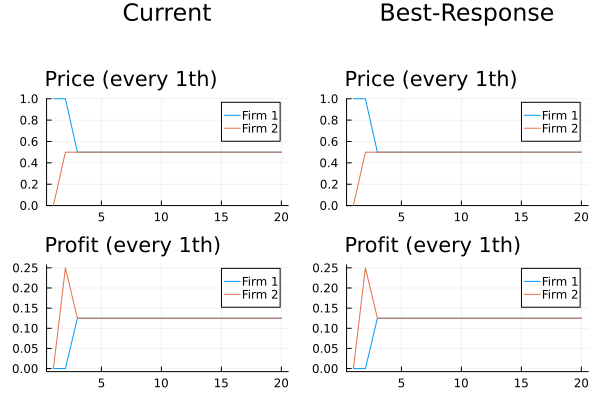

In [84]:
tprices = compete(firm1, firm2, 20)
tprofits1, tprofits2 = getprofits(tprices[1], tprices[2])

tprices_best = compete(Firm(best_response, []), firm2, 20)
tprofits_best1, tprofits_best2 = getprofits(tprices_best[1], tprices_best[2])

println("Total Firm 1 current profits = ", sum(tprofits1))
println("Total Firm 1 best-response profits = ", sum(tprofits_best1))

p1 = makeplots(tprices[1], tprices[2], tprofits1, tprofits2, 1, titled="Current")
p2 = makeplots(tprices_best[1], tprices_best[2], tprofits_best1, tprofits_best2, 1, titled="Best-Response")
plot(p1, p2)

### Competition after a forced deviation

Firm 1 deviates at t = 5. Deviation profits of 1.79 are lower than non-deviation profits of 2.25 (from best-response comparison). Firm 2 punishes Firm 1 by reducing its price further before returning to the monopoly level.

Total Firm 1 deviation profits = 1.7916666666666665


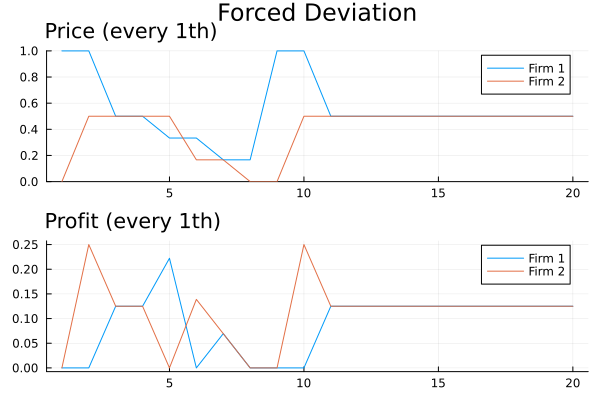

In [85]:
tprices = compete(firm1, firm2, 20, deviate = 5)
tprofits1, tprofits2 = getprofits(tprices[1], tprices[2])

println("Total Firm 1 deviation profits = ", sum(tprofits1))

makeplots(tprices[1], tprices[2], tprofits1, tprofits2, 1, titled="Forced Deviation")

## Frequency of convergence prices on multiple runs

Figure 2 in Klein 2021 had 667/1000 runs lead to a Nash equilibrium, of which 241 were at the joint-profit maximizing level (0.5, 0.5)

In [88]:
T = 500_000
runs = 50 # 1000

convg_prices = Array{Tuple{Float64, Float64}}(undef,runs)
nashcount = 0
for i in 1:runs
    firms, converged = simulate_duopoly(T)
    convg_prices[i] = (firms[1].prices[end], firms[2].prices[end])
    
    nashcount += isNash(firms[1], firms[2])
end

In [89]:
@show nashcount

nashcount = 35


35

In [90]:
freq = Dict()
for tup in convg_prices
    freq[tup] = get(freq, tup, 0) + 1
end
sorted = sort(freq, byvalue=true, rev=true)

OrderedCollections.OrderedDict{Any, Any} with 10 entries:
  (0.333333, 0.333333) => 19
  (0.5, 0.5)           => 16
  (0.166667, 1.0)      => 4
  (0.333333, 0.166667) => 3
  (0.166667, 0.666667) => 2
  (0.833333, 0.666667) => 2
  (0.166667, 0.166667) => 1
  (0.666667, 0.666667) => 1
  (0.833333, 0.5)      => 1
  (0.333333, 0.833333) => 1